In [101]:
# Importo librerie
import numpy as np
import pandas as pd
import matplotlib as mpl
import htmlGrabber
import os, json, re
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from bs4 import BeautifulSoup

In [182]:
# Organizzo working-directory
for dir in ['data/raw', 'data/tmp', 'data/final', 'images']: 
    os.makedirs(dir, exist_ok=True)

# Carico variabili d'ambiente
load_dotenv(override=True)
BASEURL = os.getenv('BASEURL')
LASTPAGE = int(os.getenv('LASTPAGE'))

## Web scraping

In [90]:
# Salvo html
G = htmlGrabber.Grabber()
G.buildUrl(baseUrl=BASEURL, pageNumbers=LASTPAGE)
G.run()
# G.exportHtml(filename='data/raw/htmlContents.json')

Output()

In [91]:
# Scraping
htmls = G.htmls
rawData = []
for html in htmls.values():
    soup = BeautifulSoup(html, 'html.parser')
    for li in soup.find_all('li'):
        brand = li.get('data-vendor')
        item = li.get('data-alpha')
        add_info = li.get('data-handle')
        price = li.select_one('h4.price')
        if pd.isna([brand, item, add_info, price]).sum() == 4:
            continue
        tmpData = {
            'brand': brand,
            'item': item,
            'add-info': add_info,
            'price': price.text if price else np.nan
        }
        rawData.append(tmpData)

## Data cleaning

In [92]:
rawdf = pd.DataFrame(rawData)
df = rawdf.copy()
df.head()

,brand,item,add-info,price
0,obey,BLAK 10 YEAR ANNIVERSARY HOODY,obey-felpa-blak-10-year-anniversary-hoody-blk,€45.00
1,obey,BLAK 10 YEAR ANNIVERSARY TEE,obey-maglietta-blak-10-year-anniversary-tee-blk,€20.00
2,huf,HUF MILANO S/S TEE BLACK,huf-t-shirt-huf-milano-s-s-tee-black-71120mc00...,€20.00
3,hurley,MAX 4 3 FULLSUIT,hurley-max-4-3-fullsuit-black,€200.00
4,edwin,PRIVATE LETTER SHORT,edwin-pantalone-corto-private-letter-short-0d2-67,€55.00


In [93]:
#
df['Brand'] = df['brand'].str.upper()
df['Item'] = df['item'].str.lower()

# Cleaning: Price 
df['Price'] = (df['price'].str.replace('€', '')).astype(np.float64)

# Create: Category
df['Category'] = pd.Series([np.nan]*df.shape[0], dtype=object)

In [94]:
# Create category - a causa dell'item con pochi dettagli non è stato possibile recuperare tutte le categorie di abbigliamento.
categoryRules = {
    'felpe': ['fleece', 'hoodie', 'sweater', 'hoody', 'hood', 'sweat', 'felp[ae]'],
    'giacche': ['jacket', 'bomber'],
    'gilet': ['cardigan', 'gilet'],
    'maglie': ['tee', 't shirt', 'knit', 'top', 'fullsuit', 'magliett[ae]'],
    'pantaloni': ['pant', 'trousers', 'jean', 'jeans'],
    'shorts': ['short'],
    'camicie': ['shirt', 'camicia'],
    'moda mare': []
}
for index, row in enumerate(df['add-info']):
    for category, rules in categoryRules.items():
        for rule in rules:
            if re.search(rule, row):
                df.loc[index, 'Category'] = category
mask = df['Category'].isna()
df.loc[mask, 'add-info'].value_counts(dropna=False).to_csv('data/tmp/itemUnclassified.csv')

In [95]:
# Final dataframe
df = df[['Brand', 'Item', 'Category', 'Price']]
df.to_csv('data/final/collectionsData.csv', index=False)

## Data analysis

### Dataset structure

In [ ]:
df = pd.read_csv('data/final/collectionsData.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266 entries, 0 to 1265
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Brand     1266 non-null   object 
 1   Item      1266 non-null   object 
 2   Category  1077 non-null   object 
 3   Price     1266 non-null   float64
dtypes: float64(1), object(3)
memory usage: 39.7+ KB


### Univariate analysis

#### Brand

In [113]:
brand = df['Brand'].value_counts(dropna=False).to_frame().reset_index()
brand['freq'] = (brand['count']/brand['count'].sum()).round(3)
brand['cumfreq'] = (brand['freq'].cumsum()).round(3)
brand['pareto'] = [1 if cumfreq <= 0.81 else 0 for cumfreq in brand['cumfreq']]
# brand['Brand_'] = [brand if pareto == 1 else 'OTHER' for brand, pareto in brand[['Brand', 'pareto']].values]
brand

,Brand,count,freq,cumfreq,pareto
0,HUF,318,0.251,0.251,1
1,OBEY,238,0.188,0.439,1
2,EDWIN,120,0.095,0.534,1
3,DARK SEAS,105,0.083,0.617,1
4,CAT WWR,91,0.072,0.689,1
5,BRIXTON,86,0.068,0.757,1
6,LOSER MACHINE,66,0.052,0.809,1
7,MINIMUM,66,0.052,0.861,0
8,OLOW,38,0.030,0.891,0
9,STANCE,34,0.027,0.918,0


i 1266 prodotti presenti nel sito web sono solamente di 12 brand. In particolare, l'80% degli articoli appartiene a 7 brand, ovvero:
1. HUF
2. OBEY
3. EDWIN
4. DARK SEAS
5. CAT WWR
6. BRIXTON
7. LOSER MACHINE

In [137]:
paretoBrand = brand[brand['pareto']==1]
paretoBrandOther = pd.DataFrame([{
    'Brand': 'OTHER',
    'count': brand.loc[brand['pareto']==0, 'count'].sum(),
    'freq': brand.loc[brand['pareto']==0, 'freq'].sum(),
    'cumfreq': brand.loc[brand['pareto']==0, 'freq'].sum(),
    'pareto': 0
}])
paretoBrand = pd.concat([paretoBrand, paretoBrandOther], ignore_index=True)
paretoBrand

,Brand,count,freq,cumfreq,pareto
0,HUF,318,0.251,0.251,1
1,OBEY,238,0.188,0.439,1
2,EDWIN,120,0.095,0.534,1
3,DARK SEAS,105,0.083,0.617,1
4,CAT WWR,91,0.072,0.689,1
5,BRIXTON,86,0.068,0.757,1
6,LOSER MACHINE,66,0.052,0.809,1
7,OTHER,242,0.191,0.191,0


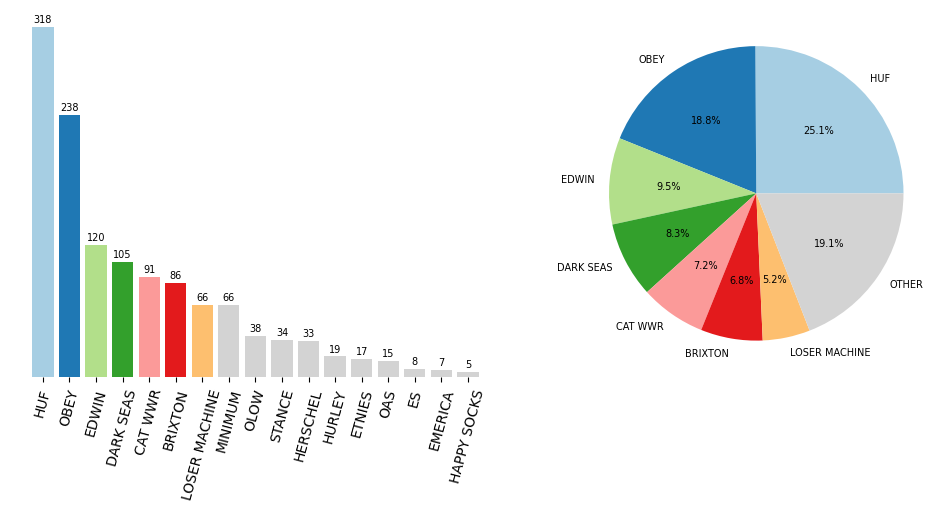

In [184]:
cmap = mpl.colormaps['Paired']
paretoBrandColors = {brand: cmap(i) for i, brand in enumerate(paretoBrand['Brand'])}
paretoBrandColors['OTHER'] = 'lightgrey'
brandColors = {brand: paretoBrandColors.get(brand, paretoBrandColors['OTHER']) for brand in brand['Brand']}
fig, ax = plt.subplots(1, 2, layout='constrained', figsize=(10, 5))
ax[0].bar(brand.index, brand['count'], color=brandColors.values())
ax[0].set_xticks(brand.index, brand['Brand'], rotation=75)
ax[0].set_yticks([])
ax[1].pie(paretoBrand['freq'], labels=paretoBrand['Brand'], colors=paretoBrandColors.values(), autopct='%1.1f%%', 
          textprops=dict(fontsize=7))

for spine in ax[0].spines.values():
    spine.set_visible(False)

for index, count in enumerate(brand['count']):
    ax[0].annotate(f'{count}', (index, count+4), ha='center', fontsize=7)

fig.savefig('images/brand.png', dpi=300)
plt.show()

#### Category

In [101]:
category = df['Category'].value_counts(dropna=True).to_frame().reset_index()
category['freq'] = category['count']/category['count'].sum()
category['cumfreq'] = category['freq'].cumsum()
category

,Category,count,freq,cumfreq
0,maglie,362,0.336119,0.336119
1,felpe,241,0.223770,0.559889
2,camicie,176,0.163417,0.723305
3,pantaloni,121,0.112349,0.835655
4,shorts,95,0.088208,0.923863
5,giacche,65,0.060353,0.984215
6,gilet,17,0.015785,1.000000


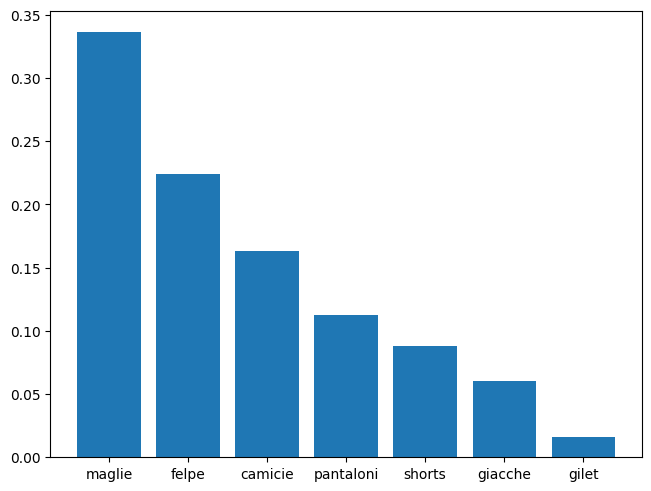

In [102]:
fig, ax = plt.subplots(layout='constrained')
ax.bar(category['Category'], category['freq'])
plt.show()

Brand       Price                           
                         mean        std     max     min
0         BRIXTON   39.034884  14.468178   72.00   13.00
1         CAT WWR   58.185714  48.251825  299.00   14.50
2       DARK SEAS   43.700000  20.159770  147.00   18.00
3           EDWIN   73.862500  36.608132  203.00   22.50
4         EMERICA   49.285714  25.929162   85.00   17.50
5              ES   28.187500  16.771442   63.00   17.50
6          ETNIES   37.294118  17.816827   75.00   15.00
7     HAPPY SOCKS   29.980000   0.000000   29.98   29.98
8        HERSCHEL   51.409091  39.841376  140.00   20.00
9             HUF   49.746541  29.335992  185.00   19.00
10         HURLEY  188.441053  47.756452  276.47  125.00
11  LOSER MACHINE   44.196970  24.527517   99.00   18.50
12        MINIMUM   53.015455  27.138161  149.98   19.98
13            OAS   57.666667  16.131897  110.00   40.00
14           OBEY   59.661765  30.343325  227.50   20.00
15           OLOW   60.750000  22.074735  111.00   22.50
16         STANCE   33.829412  16.809152   69.30   14.50

## Bivariate Analysis

In [53]:
def cv_inter(row):
    if row <= 0.2:
        v = 'bassa'
    elif (row > 0.2)and(row <= 0.4):
        v = 'moderata'
    elif (row > 0.4)and(row <= 0.6):
        v = 'alta'
    else:
        v = 'molto alta'
    return v

brandPrice = df.groupby(['Brand']).agg({'Price':['count', 'mean', 'std', 'max', 'min']})
brandPrice.columns = ['_'.join(col) for col in brandPrice.columns]
brandPrice['Price_cv'] = brandPrice['Price_std']/brandPrice['Price_mean']
brandPrice['Price_cv_comment'] = brandPrice['Price_cv'].apply(cv_inter)

with pd.option_context('display.max_rows', None):
    display(brandPrice.sort_index(level=0))

,Price_count,Price_mean,Price_std,Price_max,Price_min,Price_cv,Price_cv_comment
Brand,,,,,,,
BRIXTON,86,39.034884,14.468178,72.00,13.00,0.370647,moderata
CAT WWR,91,58.185714,48.251825,299.00,14.50,0.829273,molto alta
DARK SEAS,105,43.700000,20.159770,147.00,18.00,0.461322,alta
EDWIN,120,73.862500,36.608132,203.00,22.50,0.495625,alta
EMERICA,7,49.285714,25.929162,85.00,17.50,0.526099,alta
ES,8,28.187500,16.771442,63.00,17.50,0.594996,alta
ETNIES,17,37.294118,17.816827,75.00,15.00,0.477738,alta
HAPPY SOCKS,5,29.980000,0.000000,29.98,29.98,0.000000,bassa
HERSCHEL,33,51.409091,39.841376,140.00,20.00,0.774987,molto alta
